# ナーススケジューリング問題をD-Wave 2000Qで解く (検証編)

## 概要
記事「[ナーススケジューリング問題をD-Wave 2000Qで解く](https://qard.is.tohoku.ac.jp/T-Wave/?p=1756)」では、ナーススケジューリング問題(NSP)をD-Wave 2000Qで解くことにより、量子アニーリング(QA)の計算性能を評価する論文を紹介しました。結果として、NSPを解くことに関しては、QAよりもシミュレーテッドアニーリング(SA)の方が有用でした。しかし、この論文では制約の係数を人数や日数といった設定毎に変えていないため、係数を調整することで、より良い結果を得られる可能性があります。そこで本記事ではまず、最適だと考えられる係数を探索します。そして、その係数を用いることで、論文の結果よりも基底状態の解を見つける確率が向上するのか検証します。

## 問題

NSPの詳細については、先行研究の解説記事「[ナーススケジューリング問題をD-Wave 2000Qで解く](https://qard.is.tohoku.ac.jp/T-Wave/?p=1756)」を参照してください。

## 定式化

| 定数 | 説明 |
| ---- | ---- |
|  $n = 1 , \cdots, N$  |  看護師の人数  |
|  $d = 1 , \cdots, D$  |  日数  |
|   行列$J_{i(n, d), j\left(n, d^{\prime}\right)}=\left\{\begin{array}{cc} a>0 & d^{\prime}=d \pm 1 \\ 0 & \text { otherwise } \end{array}\right.$ |  看護師$n$が2日以上連続で勤務するとペナルティを課す  |
|  $W(d)$  |  $d$日に必要な労働力  |
|  $E(n)$  |  看護師$n$の持つ労働力  |
|  $F(n)$  |  看護師$n$が希望する勤務日数  |
|  $G(n, d) = h_{1}(n)h_{2}(d)$ |  看護師$n$が$d$日に勤務希望する  |

変数および目的関数は次のようになります。定式化の詳細は、記事「[ナーススケジューリング問題をD-Wave 2000Qで解く](nsp.md)」を参照してください。

**変数:**

$q_{n,d}$:  看護師$n$が$d$日に働く場合に1、働かない場合に0

**目的関数:**

$$
\begin{align}
H(\mathbf{q}) &= \alpha \sum_{n, n^{\prime}}^{N} \sum_{d, d^{\prime}}^{D} J_{i(n, d), j\left(n^{\prime}, d^{\prime}\right)} q_{i(n, d)} q_{j\left(n^{\prime}, d^{\prime}\right)}\\
&+ \lambda \sum_{d}^{D}\left(\sum_{n}^{N} E(n) q_{i(n, d)}-W(d)\right)^{2}\\
&+ \gamma \sum_{n}^{N}\left(\sum_{d}^{D} h_{1}(n) h_{2}(d) q_{i(n, d)}-F(n)\right)^{2}
\end{align}
$$

ただし、後述する実験のために、第一項の係数を$\alpha$としています。


論文の問題設定は次の通りでした。

| 定数 | 説明 |
| ---- | ---- |
| $N = 3, 4$ |  看護師の人数  |
| $D = 5, \cdots, 14$ |  日数  |
| $h_{1}(n) = 1$ |  全員暇  |
| $h_{2}(d) = 1$ |  常に平日  |
| $E(n) = 1$ |  全員が1人分の労働力を持つ  |
| $W(d) = 1$ |  各日に1人分の労働力が必要  |

| 目的関数・D-Waveマシンの設定 | 説明 |
| ---- | ---- |
| $a = 7/2$ |  2日以上勤務すると課されるペナルティ  |
| $\lambda = 0.3, \gamma = 1.3$ |  制約項の係数  |
| 200 $\mu s$ | アニーリング時間 |
| 1000 | サンプル数 |

本記事では、上記の設定で実験を行いました。
以下に、[PyQUBO](https://pyqubo.readthedocs.io/en/latest/)を用いたQUBO生成から最適化までのPythonコードを示します。

まず、必要なライブラリをインストールします。

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install dwave-ocean-sdk  # D-Wave Ocean SDKにPyQUBOが含まれています

次に初期設定をします。

In [1]:
N = 3  # 看護師の数
D = 14  # 日数
a = 7 / 2  # 2日以上連続で勤務した時のペナルティ
F = [4, 5, 5]  # 各看護師が希望する勤務日数

$J_{i(n, d), j\left(n, d^{\prime}\right)}=\left\{\begin{array}{cc} a>0 & d^{\prime}=d \pm 1 \\ 0 & \text { otherwise } \end{array}\right.$ は、次のように生成します。

In [2]:
from itertools import product
import numpy as np

J = np.zeros((N, D, N, D))
for n1, d1, n2, d2 in product(range(N), range(D), range(N), range(D)):
    if n1 == n2 and d1 + 1 == d2:
        J[n1, d1, n2, d2] = a

定数の設定が終わったので、定式化していきます。

In [3]:
from itertools import product
from pyqubo import Array, Constraint, Placeholder

# バイナリ変数
q = Array.create('q', shape=(N, D), vartype='BINARY')

# 2日以上連続で勤務するのを避けるための項
H1 = np.sum([J[n1, d1, n2, d2] * q[n1, d1] * q[n2, d2]
             for n1, n2, d1, d2 in product(range(N), range(N), range(D), range(D))])

# 各dに1人の看護師を確保するための項
H2 = np.sum([(np.sum([q[n,d] for n in range(N)]) - 1)**2 for d in range(D)])

# 全員の出勤回数を均等にするための項
H3 = np.sum([(np.sum([q[n,d] for d in range(D)]) - F[n])**2 for n in range(N)])

# 最小化したいQUBO
H = Placeholder('alpha') * Constraint(H1, 'H1') + Placeholder('lam') * Constraint(H2, 'H2') + Placeholder('gamma') * H3
model = H.compile()

In [4]:
feed_dict = {'alpha': 1.0, 'lam': 1.3, 'gamma': 0.3} # 制約項の係数
bqm = model.to_bqm(feed_dict=feed_dict)

ここで、サンプラーの設定をします。

In [5]:
# SAの場合
# from neal import SimulatedAnnealingSampler
# sampler = SimulatedAnnealingSampler()

# D-Waveマシンの場合
from dwave.system import DWaveSampler, EmbeddingComposite
sampler_config = {'solver': 'DW_2000Q_6', 'token': 'YOUR_TOKEN'}
sampler = EmbeddingComposite(DWaveSampler(**sampler_config))

全ての設定が終わりました。
いよいよアニーリングを実行します。



In [6]:
num_reads = 1000
sampleset = sampler.sample(bqm, num_reads=num_reads)

得られた解は、次のように確認できます。

In [7]:
sampleset.record[:10]

rec.array([([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0], 1.76214598e-12, 1),
           ([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0], 1.76214598e-12, 1),
           ([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1], 1.75504056e-12, 1),
           ([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], 1.75504056e-12, 1),
           ([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0], 6.00000000e-01, 1),
           ([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0], 1.75504056e-12, 1),
           ([1, 0, 0, 1, 0, 0, 0, 0, 0, 

`sampleset.record`には、

- 解の状態
- エネルギー
- 解の個数
- チェーンブレイク

の割合の順番で格納されています。本実験では基底状態のとき、`energy == 0`となるように入力を設定しています。

次に、制約条件を満たしている解を取り出します。

In [8]:
def extract_feasible_samples(samples, print_broken=False):
    feasible_samples = []
    for sample in decoded_samples:
        constraints = sample.constraints(only_broken=True)
        if len(constraints) == 0:
            feasible_samples.append(sample)
        elif print_broken:
            print(constraints)
    return feasible_samples

In [9]:
decoded_samples = model.decode_sampleset(sampleset.aggregate(), feed_dict)
feasible_samples = extract_feasible_samples(decoded_samples)
print('実行可能解の個数:', len(feasible_samples))

実行可能解の個数: 897


得られた解で最もエネルギーの低い解を可視化します。

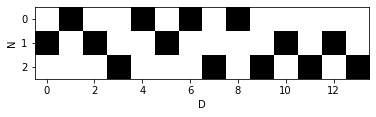

In [10]:
import matplotlib.pyplot as plt

lowest_sample = feasible_samples[0].sample

schedules = np.zeros((N, D))
for n in range(N):
    for d in range(D):
        if lowest_sample[f'q[{n}][{d}]'] == 1:
            schedules[n, d] = 1

plt.imshow(schedules, cmap="Greys")
plt.xlabel('D')
plt.ylabel('N')
plt.show()

各看護師が希望する勤務日数と実際の日数が、どの程度近いかを確認します。

In [11]:
print('実際の勤務日数:', np.sum(schedules, axis=1))
print('希望する勤務日数:', F)

実際の勤務日数: [4. 5. 5.]
希望する勤務日数: [4, 5, 5]


## 実験
### 「基底状態の解を見つける確率」の求め方

本実験は、「基底状態の解を見つける確率(%)」を求めることが目的です。これは、次の式で求められます。本実験では基底状態のとき、`energy == 0`となるように入力を設定しています。

[`energy == 0`の個数] / [`num_reads`] × 100

In [12]:
def calc_probability(samples, num_reads):
    return sum(1 for sample in samples if abs(sample.energy) < 1e-9) / num_reads * 100

### 係数の探索方法
最適と考えられる係数は次のように探索しました。

![制約項の重みの調整方法](figures/adjustment_coefficients.png)

まず、ソフト制約である第3項の係数$\gamma$を1.0に固定します。そして、第1項の係数$\alpha$=第2項の係数$\lambda$=1.0からスタートし、両方とも10.0になるまで1.0ずつ動かします.
それぞれの係数で「基底状態を見つける確率」をD-Wave 2000Qで計算し、確率が最も高くなった係数を採用します。この探索を$d$(日数)毎に実行します。次に、係数探索を行うコードを示します。

In [ ]:
lam_list = np.arange(1, 11)
alpha_list = np.arange(1, 11)

prob_hists = {}
for lam in lam_list:
    for alpha in alpha_list:
        print(f'lam: {lam}, alpha: {alpha}')
        # 制約の係数を変更
        feed_dict = {'alpha': alpha, 'lam': lam, 'gamma': 1.0}
        bqm = model.to_bqm(feed_dict=feed_dict)

        # アニーリング
        sampleset = sampler.sample(bqm, num_reads=num_reads)
        decoded_samples = model.decode_sampleset(sampleset.aggregate(), feed_dict)
        feasible_samples = extract_feasible_samples(decoded_samples)

        # 確率を求める
        prob_hists[(alpha, lam)] = calc_probability(feasible_samples, num_reads)

以下の図は、$N=3,D=5$の時のヒートマップです。この場合、第1項の係数$\alpha=3.0$、第2項の係数$\lambda=2.0$にすると最適な結果が得られると考えられます。

![制約項の重みの調整結果](figures/result1_exp.png)

### 結果

以下の図から、係数を調整することで精度は向上することが分かります。しかし、先行研究と同様、日数$D$が大きくなると確率はかなり低くなってしまいました。

![論文の再現結果との比較 (adjustedは係数を調整した場合、replicatedは論文の再現実験をした場合)](figures/result2_exp.png)

## 結論

本記事では、制約項の係数調整を行うことで、論文よりもNSPを精度良く解くことが出来るのかを検証しました。係数調整により精度は向上したものの、日数が大きくなると、基底状態の解はほとんど得られませんでした。

## あと書き

最大で56変数の問題に対して、基底状態の解を上手く見つけられないのは残念でした。本記事よりも、より細かく係数探索を行うことで精度向上の余地はありますが、日数が大きくなるにつれてほとんど解けなくなるのは変わらないと考えられます。他に精度を向上させる方法として埋め込みを自分で設定する方法がありますが、現在の自分の知識ではどのような埋め込みを行えば良いのか分かりません。またこの結果では、せいぜい1週間のシフトしか組めないため、実用化は難しいと思います。最低でも1か月のスケジュールを作れるようになったら、もう1度実験を行ってみたいです。

### 本記事の担当者
鹿内怜央